<h3>Import Libraries</h3>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
plt.style.use('ggplot')

import spacy;
import os
print(os.listdir("../input"))

Using TensorFlow backend.


['glove-global-vectors-for-word-representation', 'yelp-reviews-csv']


In [4]:
#chunksize = 10 ** 5
yelp_reviews=pd.read_csv("../input/yelp-reviews-csv/yelp_review.csv",usecols=["stars","text"])
#yelp_reviews=pd.concat(yelp_reviews)
yelp_reviews.head(2)

,stars,text
0,5,Super simple place but amazing nonetheless. It...
1,5,Small unassuming place that changes their menu...


In [5]:
#let's check out a sample review
yelp_reviews.text[5]

"Cycle Pub Las Vegas was a blast! Got a groupon and rented the bike for 11 of us for an afternoon tour. Each bar was more fun than the last. Downtown Las Vegas has changed so much and for the better. We had a wide age range in this group from early 20's to mid 50's and everyone had so much fun! Our driver Tony was knowledgable , friendly and just plain fun! Would recommend this to anyone looking to do something different away from the strip. You won't be disappointed!"

In [6]:
##checking for nulls
yelp_reviews.isnull().any()

stars    False
text     False
dtype: bool

Great we dont have enemies!
<a id='preparation'></a>

### Preparing Text Data

In [7]:
yelp_reviews.stars.unique()

array([5, 4, 3, 1, 2])

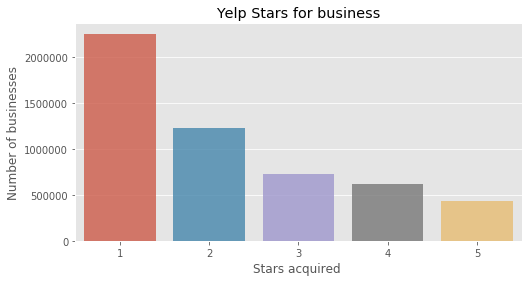

In [8]:
x=yelp_reviews['stars'].value_counts()
y=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(y.index, x.values, alpha=0.8)
plt.title("Yelp Stars for business")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Stars acquired ', fontsize=12);

We will be doing binary classification for sake of simplicity. So, converting stars column as binary column. We can keep neutral class as stars =3 but right now we will just stick to two classes.

In [9]:
reviews=yelp_reviews[:300000]
reviews=reviews[reviews.stars!=3]

reviews["labels"]= reviews["stars"].apply(lambda x: 1 if x > 3  else 0)
reviews=reviews.drop("stars",axis=1)

reviews.head()


,text,labels
0,Super simple place but amazing nonetheless. It...,1
1,Small unassuming place that changes their menu...,1
2,Lester's is located in a beautiful neighborhoo...,1
3,Love coming here. Yes the place always needs t...,1
4,Had their chocolate almond croissant and it wa...,1


In [10]:
texts = reviews["text"].values
labels = reviews["labels"].values

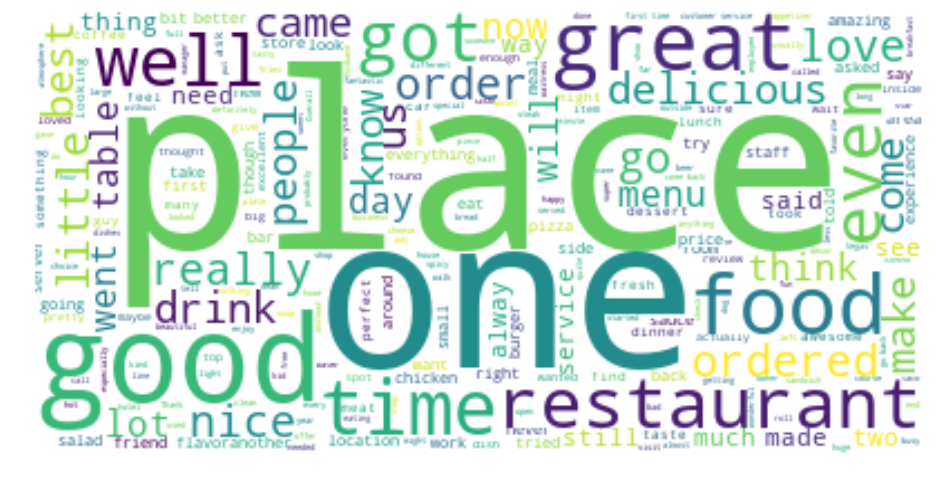

In [11]:
import imageio
import codecs
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(background_color="white", max_words=3000, 
               stopwords=STOPWORDS)
# generate word cloud
wc.generate(" ".join(texts[:10000]))

# cloud
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");



### Converting text into numerical representation i.e Tensors
Then we can format our text samples and labels into tensors that can be fed into a neural network. 
Some Preprocessing is needed here like Tokenization



In [12]:
MAX_NUM_WORDS=1000 # how many unique words to use 
MAX_SEQUENCE_LENGTH=100 # max number of words in a review to use

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Found 155745 unique tokens.
Shape of data tensor: (265809, 100)
Shape of label tensor: (265809, 2)


<a id='split'></a>

###  split the data into a training set and a validation set

In [13]:
VALIDATION_SPLIT=0.2

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

<a id='embedding_layer'></a>

### Preparing the Embedding layer

In [14]:
GLOVE_DIR='../input/glove-global-vectors-for-word-representation'

import os
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'),encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coef = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coef
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


<a id='embedding_matrix'></a>


### compute  embedding matrix
At this point we can leverage our embedding_index dictionary and our word_index to compute our embedding matrix


In [15]:
EMBEDDING_DIM = 50 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector

### Define Embedding Layer 
 We load this embedding matrix into an Embedding layer. Note that we set trainable=False to prevent the weights from being updated during training.


In [16]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


### Training model...finally!

In [17]:
from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

from keras.models import Model

inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(2, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128);

Train on 212648 samples, validate on 53161 samples
Epoch 1/10
212648/212648 [==============================] - 799s 4ms/step - loss: 0.1853 - acc: 0.9244 - val_loss: 0.1704 - val_acc: 0.9309
Epoch 2/10
212648/212648 [==============================] - 800s 4ms/step - loss: 0.1730 - acc: 0.9300 - val_loss: 0.1687 - val_acc: 0.9316
Epoch 3/10
212648/212648 [==============================] - 793s 4ms/step - loss: 0.1639 - acc: 0.9349 - val_loss: 0.1627 - val_acc: 0.9345
Epoch 4/10
212648/212648 [==============================] - 792s 4ms/step - loss: 0.1570 - acc: 0.9373 - val_loss: 0.1611 - val_acc: 0.9351
Epoch 5/10
212648/212648 [==============================] - 798s 4ms/step - loss: 0.1517 - acc: 0.9393 - val_loss: 0.1474 - val_acc: 0.9408
Epoch 6/10
212648/212648 [==============================] - 786s 4ms/step - loss: 0.1473 - acc: 0.9417 - val_loss: 0.1455 - val_acc: 0.9416
Epoch 7/10
212648/212648 [==============================] - 787s 4ms/step - loss: 0.1434 - acc: 0.9429 - val_

This gives us 94% accuracy. Thats not enough may be we should bring on more data.


### Hands on Spacy


In [20]:
import spacy
nlp = spacy.load('en')
sample_review=reviews.text[5]
sample_review


"Cycle Pub Las Vegas was a blast! Got a groupon and rented the bike for 11 of us for an afternoon tour. Each bar was more fun than the last. Downtown Las Vegas has changed so much and for the better. We had a wide age range in this group from early 20's to mid 50's and everyone had so much fun! Our driver Tony was knowledgable , friendly and just plain fun! Would recommend this to anyone looking to do something different away from the strip. You won't be disappointed!"

In [21]:
%%time
parsed_review = nlp(sample_review)
print(parsed_review)

Cycle Pub Las Vegas was a blast! Got a groupon and rented the bike for 11 of us for an afternoon tour. Each bar was more fun than the last. Downtown Las Vegas has changed so much and for the better. We had a wide age range in this group from early 20's to mid 50's and everyone had so much fun! Our driver Tony was knowledgable , friendly and just plain fun! Would recommend this to anyone looking to do something different away from the strip. You won't be disappointed!
CPU times: user 56 ms, sys: 40 ms, total: 96 ms
Wall time: 119 ms


looks like nothing changed. 
Let's check againn.
### Sentence detection and segmentation



In [22]:
for num, sentence in enumerate(parsed_review.sents):
    print ('Sentence {}:'.format(num + 1))
    print (sentence)
    print ('\n')

Sentence 1:
Cycle Pub Las Vegas was a blast!


Sentence 2:
Got a groupon and rented the bike for 11 of us for an afternoon tour.


Sentence 3:
Each bar was more fun than the last.


Sentence 4:
Downtown Las Vegas has changed so much and for the better.


Sentence 5:
We had a wide age range in this group from early 20's to mid 50's and everyone had so much fun!


Sentence 6:
Our driver Tony was knowledgable , friendly and just plain fun!


Sentence 7:
Would recommend this to anyone looking to do something different away from the strip.


Sentence 8:
You won't be disappointed!




### Named entity detection

In [23]:
for num, entity in enumerate(parsed_review.ents):
    print ('Entity {}:'.format(num + 1), entity, '-', entity.label_)
    print ('\n')

Entity 1: Las Vegas - GPE


Entity 2: 11 - CARDINAL


Entity 3: Las Vegas - GPE


Entity 4: mid 50's - DATE


Entity 5: Tony - PERSON




### Part of speech tagging

In [24]:
token_text = [token.orth_ for token in parsed_review]
token_pos = [token.pos_ for token in parsed_review]

parts_of_speech=pd.DataFrame(data=list(zip(token_text, token_pos)),columns=['token_text', 'part_of_speech'])
parts_of_speech.head(10)

,token_text,part_of_speech
0,Cycle,PROPN
1,Pub,PROPN
2,Las,PROPN
3,Vegas,PROPN
4,was,VERB
5,a,DET
6,blast,NOUN
7,!,PUNCT
8,Got,VERB
9,a,DET


### Text normalization, like stemming/lemmatization and shape analysis



In [26]:
token_lemma = [token.lemma_ for token in parsed_review]
token_shape = [token.shape_ for token in parsed_review]

text_normalized_DF=pd.DataFrame(list(zip(token_text, token_lemma, token_shape)),
             columns=['token_text', 'token_lemma', 'token_shape'])
text_normalized_DF.head()

,token_text,token_lemma,token_shape
0,Cycle,cycle,Xxxxx
1,Pub,pub,Xxx
2,Las,las,Xxx
3,Vegas,vegas,Xxxxx
4,was,be,xxx


### Token-level entity analysis


In [27]:
token_entity_type = [token.ent_type_ for token in parsed_review]
token_entity_iob = [token.ent_iob_ for token in parsed_review]

entity_analysis=pd.DataFrame(list(zip(token_text, token_entity_type, token_entity_iob)),
             columns=['token_text', 'entity_type', 'inside_outside_begin'])
entity_analysis.head()

,token_text,entity_type,inside_outside_begin
0,Cycle,,O
1,Pub,,O
2,Las,GPE,B
3,Vegas,GPE,I
4,was,,O


### Token  attributes

such as the relative frequency of tokens, and whether or not a token matches any of these categories

stopword
punctuation
whitespace
represents a number
whether or not the token is included in spaCy's default vocabulary?

In [28]:
token_attributes = [(token.orth_,
                     token.prob,
                     token.is_stop,
                     token.is_punct,
                     token.is_space,
                     token.like_num,
                     token.is_oov)
                    for token in parsed_review]

token_attributes = pd.DataFrame(token_attributes,
                  columns=['text',
                           'log_probability',
                           'stop?',
                           'punctuation?',
                           'whitespace?',
                           'number?',
                           'out of vocab.?'])

token_attributes.loc[:, 'stop?':'out of vocab.?'] = (token_attributes.loc[:, 'stop?':'out of vocab.?']
                                       .applymap(lambda x: u'Yes' if x else u''))
                                               
token_attributes.head()

,text,log_probability,stop?,punctuation?,whitespace?,number?,out of vocab.?
0,Cycle,-20.0,,,,,Yes
1,Pub,-20.0,,,,,Yes
2,Las,-20.0,,,,,Yes
3,Vegas,-20.0,,,,,Yes
4,was,-20.0,Yes,,,,Yes
